In [1]:
import pandas as pd
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from utils.utils import *
from segmentation.segmentation import Segmentation
from sklearn import preprocessing
path = '../stats_files/'

In [2]:
dt = DataLoader()
dt.load('../sample_testing/sample2.log')
dt.extractinfo(export=False,single_file=False)

mongodb://localhost:27017/
Database connected


Batch Size:  100
Signal Run Time: 0.18749046325683594 , Growth Rate: 0.0
Batch Size:  100
Signal Run Time: 0.08975982666015625 , Growth Rate: 0.5
Batch Size:  100
Signal Run Time: 0.07480049133300781 , Growth Rate: 1.0
Batch Size:  100
Signal Run Time: 0.05684852600097656 , Growth Rate: 1.5


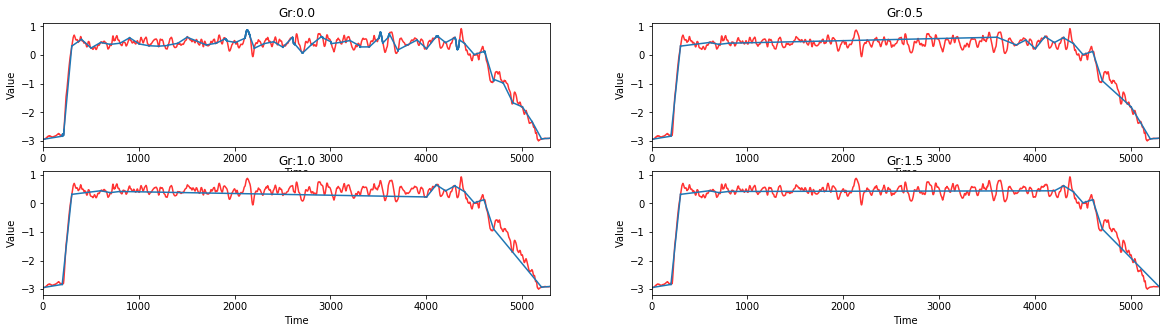

In [3]:
runvsg = []
plt.figure(figsize=(20,5))
for i,gr in enumerate(np.arange(0,2,0.5)):
    start_time = time.time()
    sg = Segmentation(1)
    comp ='GPS'
    va = 'Alt'
    fitmethod= 'inter'
    sgmethod = 'td'
    sr = dt.dbconnector.query(comp+'_568c058bb560505c22dc402c',va)
    sig_length = len(sr)
    rng = dt.dbconnector.query(comp+'568c058bb560505c22dc402c','lineIndex')
    sg.segment(preprocessing.scale(sr),seg_method=sgmethod,fit_method=fitmethod,save_seginstance=False,err_growth=gr,batch_size=100)
    print('Signal Run Time: {} , Growth Rate: {}'.format( time.time() - start_time,gr))
    runvsg.append( time.time() - start_time)
    plt.subplot(2, 2, i+1)
    sg.draw_plot('Gr:'+str(gr))#+'-'+comp+'_'+va
    sg.draw_segments()
plt.show()
#plt.legend()
    #plt.savefig('../report/phase3/'+comp+'_'+va+'_'+sgmethod+'_'+fitmethod+'.png', dpi=500)

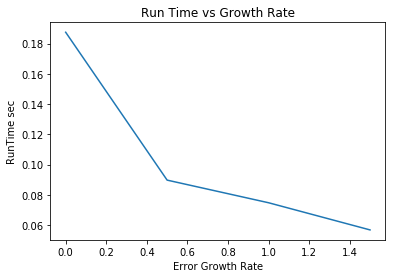

In [4]:
l = list(np.arange(0,2,0.5))
sns.lineplot(x=l,y=runvsg)
plt.title('Run Time vs Growth Rate')
plt.xlabel('Error Growth Rate')
plt.ylabel('RunTime sec')
plt.show()

In [2]:
datalist =os.listdir('../data')
#added to the 100 variables
vardict = load_top100_dict()
vardict['RCOU'] = ['RCOU_Ch1','RCOU_Ch2','RCOU_Ccmdh3','RCOU_Ch4']

In [3]:
dbc = DatabaseConnector('segdb','27017')

mongodb://localhost:27017/
Database connected


In [4]:
loader = DataLoader()

mongodb://localhost:27017/
Database connected


In [ ]:
existing_collections = dbc.mydb.list_collection_names()
sg = Segmentation(1)
insert_data = True
check_insert =True
normalize = False
batch_size = 70
#------------------------------------------
time_list = []
fitmethod= 'inter'
sgmethod = 'td'
for i,log in enumerate(datalist):
    start_time = time.time()
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    for k,v in vardict.items():
        batch_size = 50
        res = loader.dbconnector.query(k+'_'+log[:-4]) #find signals in the log files 
        if res != -1: #data exists
                df = pd.DataFrame(res)
                df_size = len(df)
                print('Processing Component: {}.. Length: {}'.format(k,df_size))
                if df_size <= 5:
                    continue
#                 if df_size > 2000:
#                         batch_size = batch_size * ((df_size / 2000)/2) #increase the batch size if file is large
                for val in list(set(df.columns).intersection(v)): #loop through the signals
                    cname = 'seg_'+k+'_'+val+'_'+log[:-4]
                    if cname in existing_collections:
                        continue
                    #print('        Signal: {}..'.format(val,df_size))
                    if not np.issubdtype(df[val].dtype, np.number):
                            cat_to_int(df,val)
                    if normalize:
                        srval = preprocessing.scale(df[val])
                    else:
                        srval = df[val]
                    list_segments = sg.segment(srval,seg_method=sgmethod,fit_method=fitmethod,
                                               save_seginstance=False,err_growth = 1,batch_size=batch_size)
                    if isinstance(list_segments,int):
                        print('error in segments ', list_segments)
                        continue
                    #export list_segments into a collection
                    if insert_data:
                            if cname not in existing_collections:
                                time_list.append(time.time() - start_time)
                            dbc.set_collection(cname)
                            resp = dbc.insert_dict(pd.DataFrame(list_segments,columns=['x1','y1','x2','y2']).to_dict('list'))
                            if resp == -1:
                                print('Dict insert error in file : {}'.format(log[:-4]))
    print('File Run Time: ', time.time() - start_time)

File:568c058bb560505c22dc402c.log --  0 / 2607
Processing Component: MODE.. Length: 2
Processing Component: GPS.. Length: 5296
Processing Component: DU32.. Length: 0
Processing Component: ATT.. Length: 52966
Processing Component: EV.. Length: 0
Processing Component: CURR.. Length: 1059
Processing Component: PM.. Length: 106
Processing Component: PARM.. Length: 543
Processing Component: MSG.. Length: 1821
Processing Component: CTUN.. Length: 10591
Processing Component: NTUN.. Length: 10591
Processing Component: IMU.. Length: 52962
Processing Component: RCIN.. Length: 10591
Processing Component: BARO.. Length: 10592
Processing Component: ERR.. Length: 0
Processing Component: RAD.. Length: 2087
Processing Component: MAG.. Length: 10592
Processing Component: RCOU.. Length: 10591
File Run Time:  1.4387648105621338
File:568c0b3a7132fa902e401d31.log --  1 / 2607
Processing Component: MODE.. Length: 3
Processing Component: GPS.. Length: 2933
Processing Component: DU32.. Length: 0
Processing Co

Processing Component: PARM.. Length: 512
Processing Component: MSG.. Length: 2
Processing Component: CTUN.. Length: 3140
Processing Component: NTUN.. Length: 169
Processing Component: IMU.. Length: 11121
Processing Component: RCIN.. Length: 3027
Processing Component: BARO.. Length: 3140
Processing Component: ERR.. Length: 1
Processing Component: RAD.. Length: 315
Processing Component: MAG.. Length: 3140
Processing Component: RCOU.. Length: 3027
File Run Time:  0.14171385765075684
File:56f6af7385e739af3b3cb427.log --  11 / 2607
Processing Component: MODE.. Length: 8
Processing Component: GPS.. Length: 1687
Processing Component: DU32.. Length: 337
Processing Component: ATT.. Length: 3280
Processing Component: EV.. Length: 5
Processing Component: CURR.. Length: 337
Processing Component: PM.. Length: 34
Processing Component: PARM.. Length: 306
Processing Component: MSG.. Length: 2
Processing Component: CTUN.. Length: 3354
Processing Component: NTUN.. Length: 164
Processing Component: IMU..

Processing Component: BARO.. Length: 0
Processing Component: ERR.. Length: 0
Processing Component: RAD.. Length: 0
Processing Component: MAG.. Length: 0
Processing Component: RCOU.. Length: 0
File Run Time:  50.197181940078735
File:575ed4c688bc9002549dfb67.log --  21 / 2607
Processing Component: MODE.. Length: 4
Processing Component: GPS.. Length: 3058
Processing Component: DU32.. Length: 610
Processing Component: ATT.. Length: 6105
